In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-poster')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

## probes

In [3]:
db_layers = [0, 1, 4, 5, 6]
b_layers = [0, 1, 6, 10, 11, 12]
full_words = {
    'indiv': 'Individual',
    'cond': 'Conditional',
    'pos': 'Part-of-Speech',
    'dep': 'Dependency',
    'ner': 'Named Entity Recognition',
}

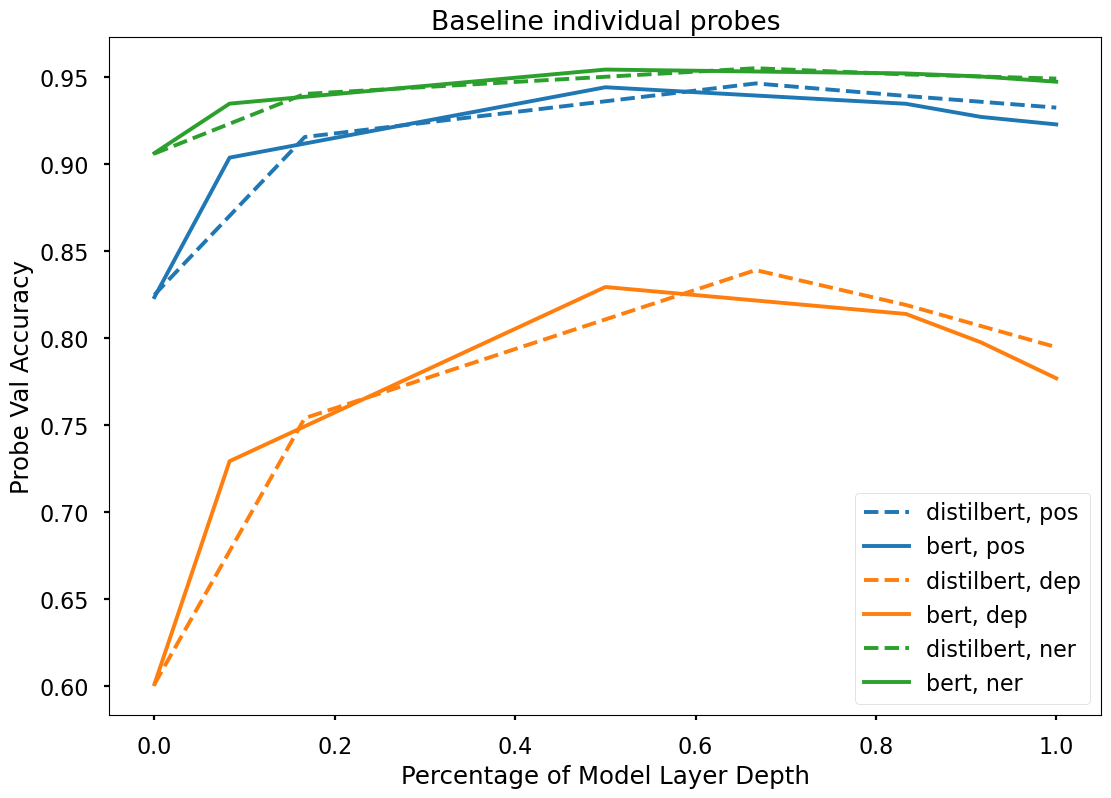

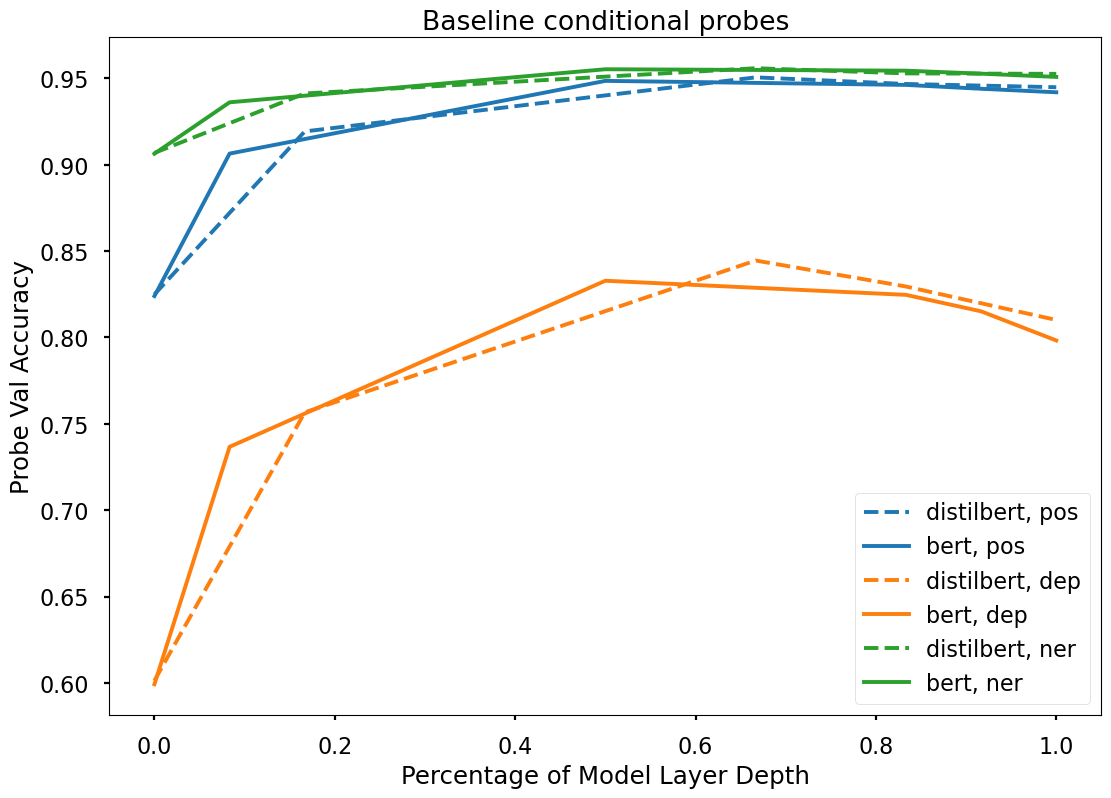

In [12]:
df = pd.read_csv('data/probe_outputs.csv')
for ptype in ['indiv', 'cond']:
    fig, ax = plt.subplots(1)
    ax.set_title(f"Baseline {full_words[ptype].lower()} probes")
    ax.set_xlabel('Percentage of Model Layer Depth')
    ax.set_ylabel('Probe Val Accuracy')
    for k,t in enumerate(['pos', 'dep', 'ner']):
        for model in ['distilbert', 'bert']:
            layers = b_layers if model == 'bert' else db_layers
            layer_names = [f'layer{i}' for i in layers]
            tune_types = ['none']
            # if model == 'distilbert':
            #     tune_types += ['mixedmnli']
            subdf = df[(df['m_arch'] == model) & (df['p_type'] == ptype) & (df['p_task'] == t)]
            data_slice = subdf[subdf['m_finetune'] == 'none'][layer_names]
            layer_pcts = [l / max(layers) for l in layers]
            ax.plot(layer_pcts, data_slice.values.flatten(), label=f'{model}, {t}', color=COLORS[k], \
                    linestyle='solid' if model == 'bert' else 'dashed')
    ax.legend()
    plt.show()

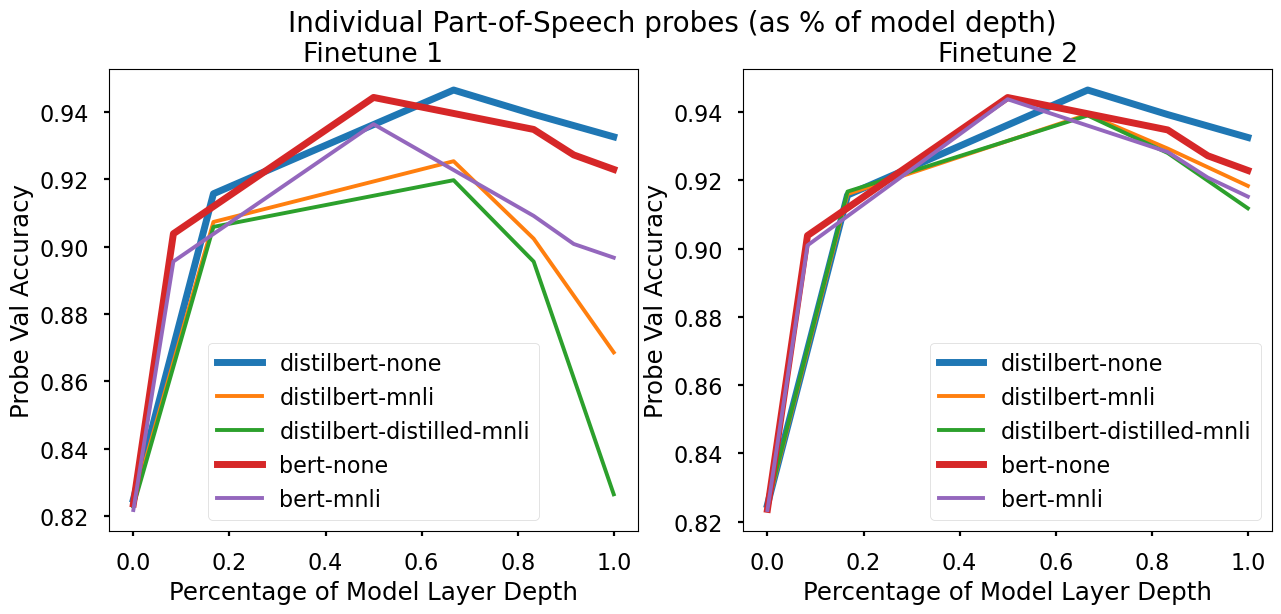

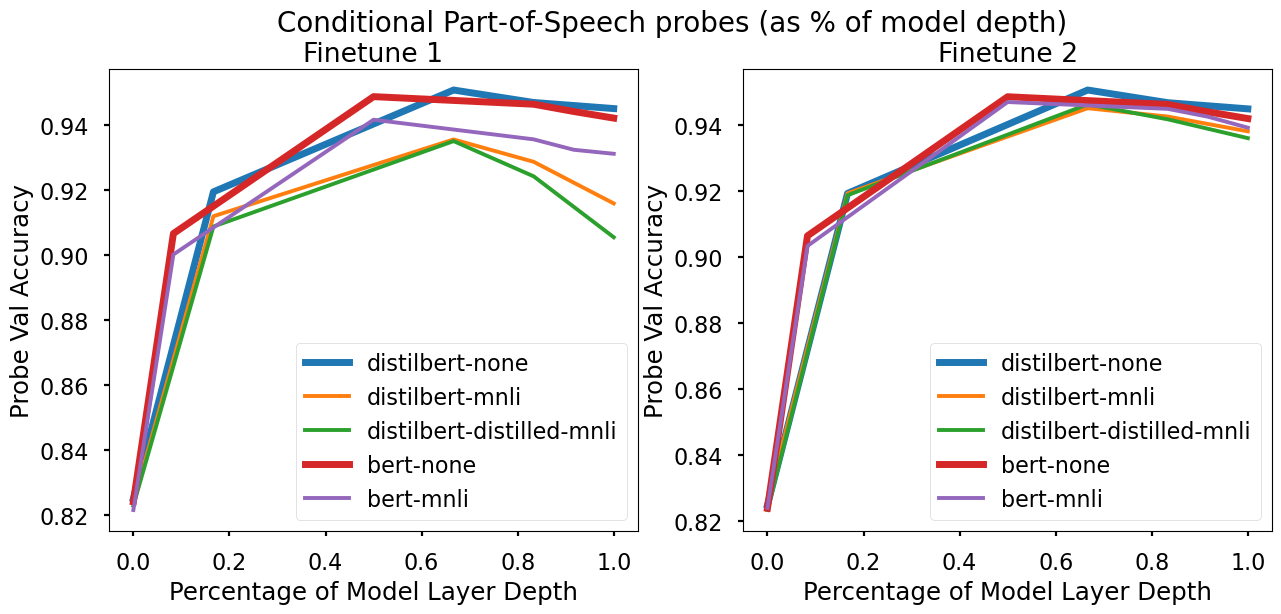

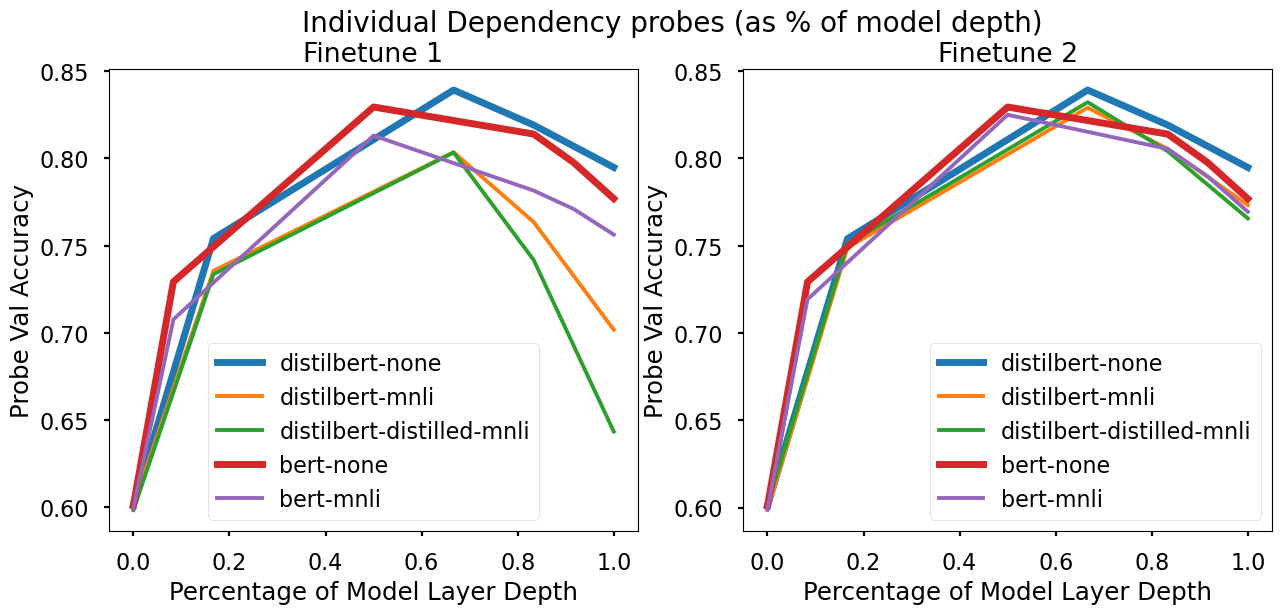

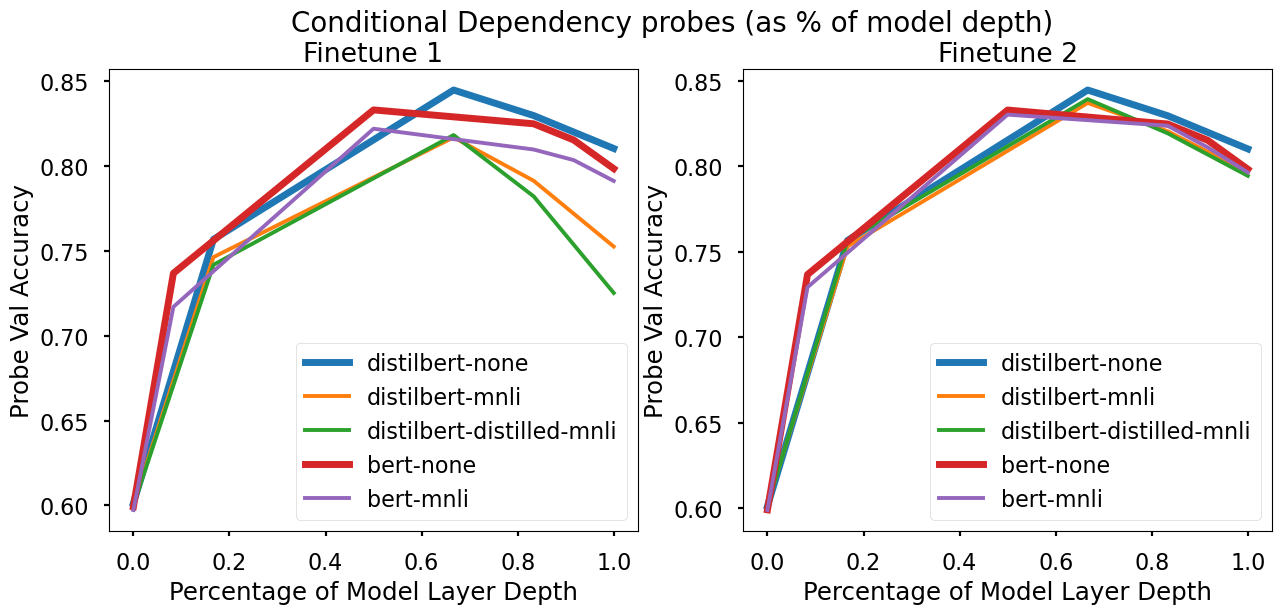

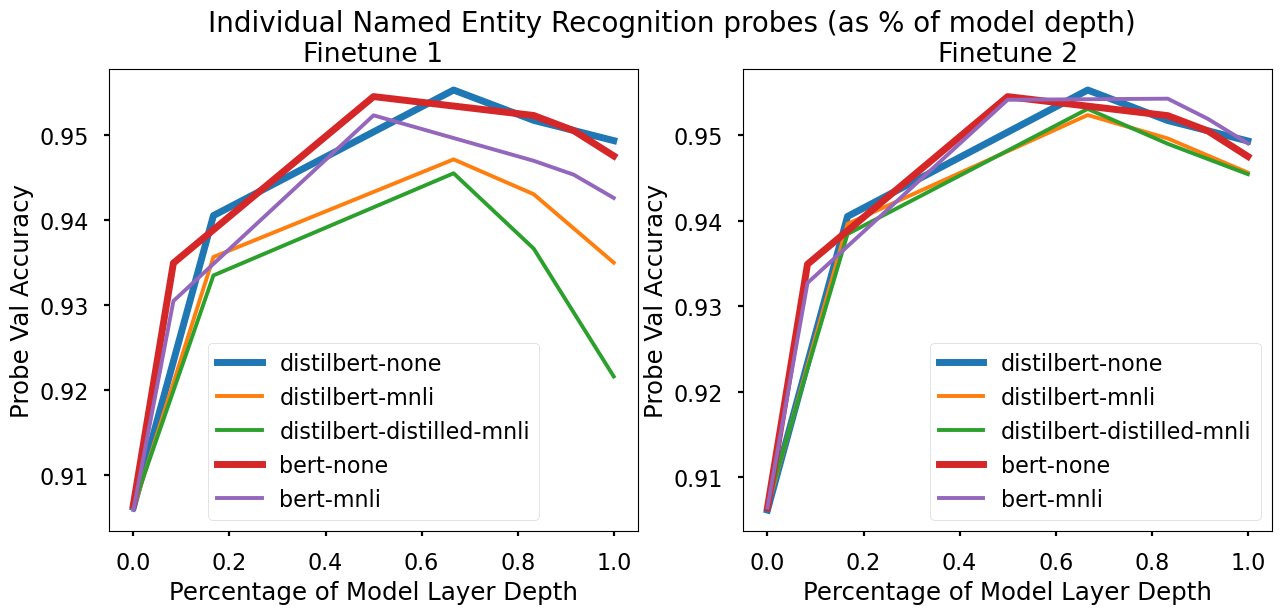

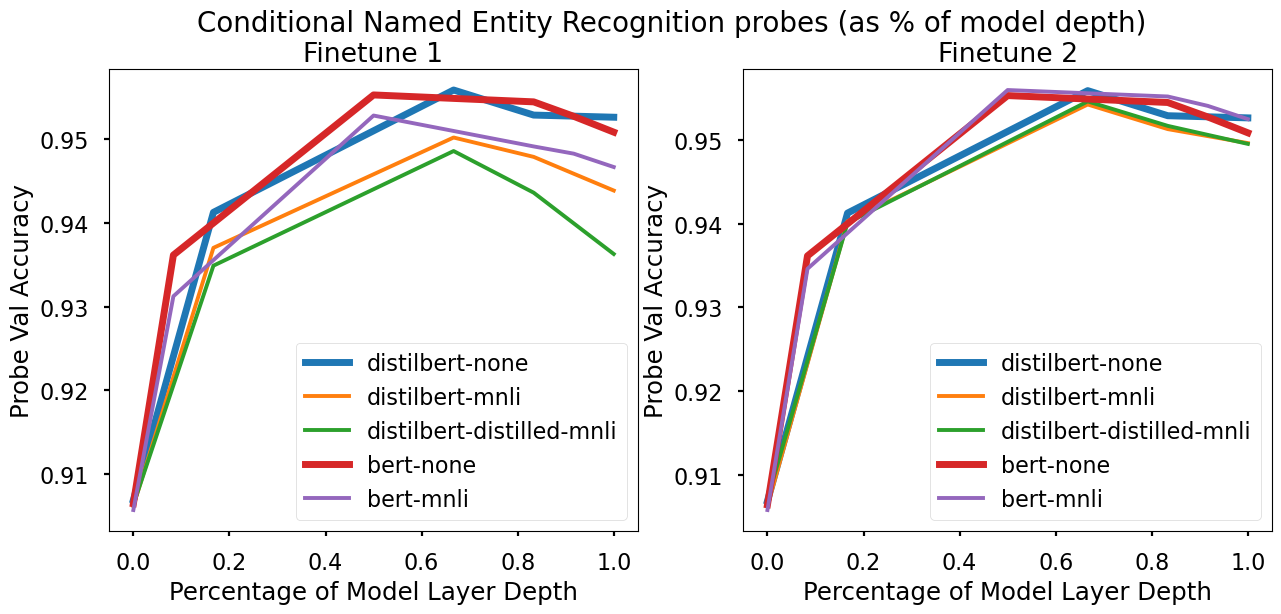

In [19]:
df = pd.read_csv('data/probe_outputs.csv')
df_old = pd.read_csv('data/probe_outputs_old.csv')
for t in ['pos', 'dep', 'ner']:
    for ptype in ['indiv', 'cond']:
        fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
        i = 0
        for model in ['distilbert', 'bert']:
            layers = b_layers if model == 'bert' else db_layers
            layer_names = [f'layer{i}' for i in layers]
            tune_types = ['none', 'mnli']
            if model == 'distilbert':
                tune_types += ['mixedmnli']
            subdf = df[(df['m_arch'] == model) & (df['p_type'] == ptype) & (df['p_task'] == t)]
            subdf_old = df_old[(df_old['m_arch'] == model) & (df_old['p_type'] == ptype) & (df_old['p_task'] == t)]
            fig.suptitle(f"{full_words[ptype]} {full_words[t]} probes (as % of model depth)", size=20)
            ax[0].set_title('Finetune 1')
            ax[1].set_title('Finetune 2')
            ax[0].set_xlabel('Percentage of Model Layer Depth')
            ax[1].set_xlabel('Percentage of Model Layer Depth')
            ax[0].set_ylabel('Probe Val Accuracy')
            ax[1].set_ylabel('Probe Val Accuracy')
            for tt in tune_types:
                data_ = subdf[subdf['m_finetune'] == tt][layer_names]
                data_old_ = subdf_old[subdf_old['m_finetune'] == tt][layer_names]
                layer_pcts = [l / max(layers) for l in layers]
                tt = tt.replace('mixedmnli', 'distilled-mnli')
                if tt == 'none':
                    ax[0].plot(layer_pcts, data_.values.flatten(), label=f'{model}-{tt}', color=COLORS[i], linewidth=5)
                    ax[1].plot(layer_pcts, data_.values.flatten(), label=f'{model}-{tt}', color=COLORS[i], linewidth=5)
                else:
                    ax[1].plot(layer_pcts, data_.values.flatten(), label=f'{model}-{tt}', color=COLORS[i])
                    ax[0].plot(layer_pcts, data_old_.values.flatten(), label=f'{model}-{tt}', color=COLORS[i])
                i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()

## Generalization

In [5]:
def get_bar_plots(tasks, model_accs):
    x = np.arange(len(tasks)) 
    width = 0.15
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    vals = []
    for attribute, measurement in model_accs.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, fmt='%.3f', padding=3)
        multiplier += 1    
        vals.append(measurement)
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance by NLI Task')
    ax.set_xticks(x + width, tasks)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(np.min(vals)-.1, np.max(vals)+.1)

    plt.show()

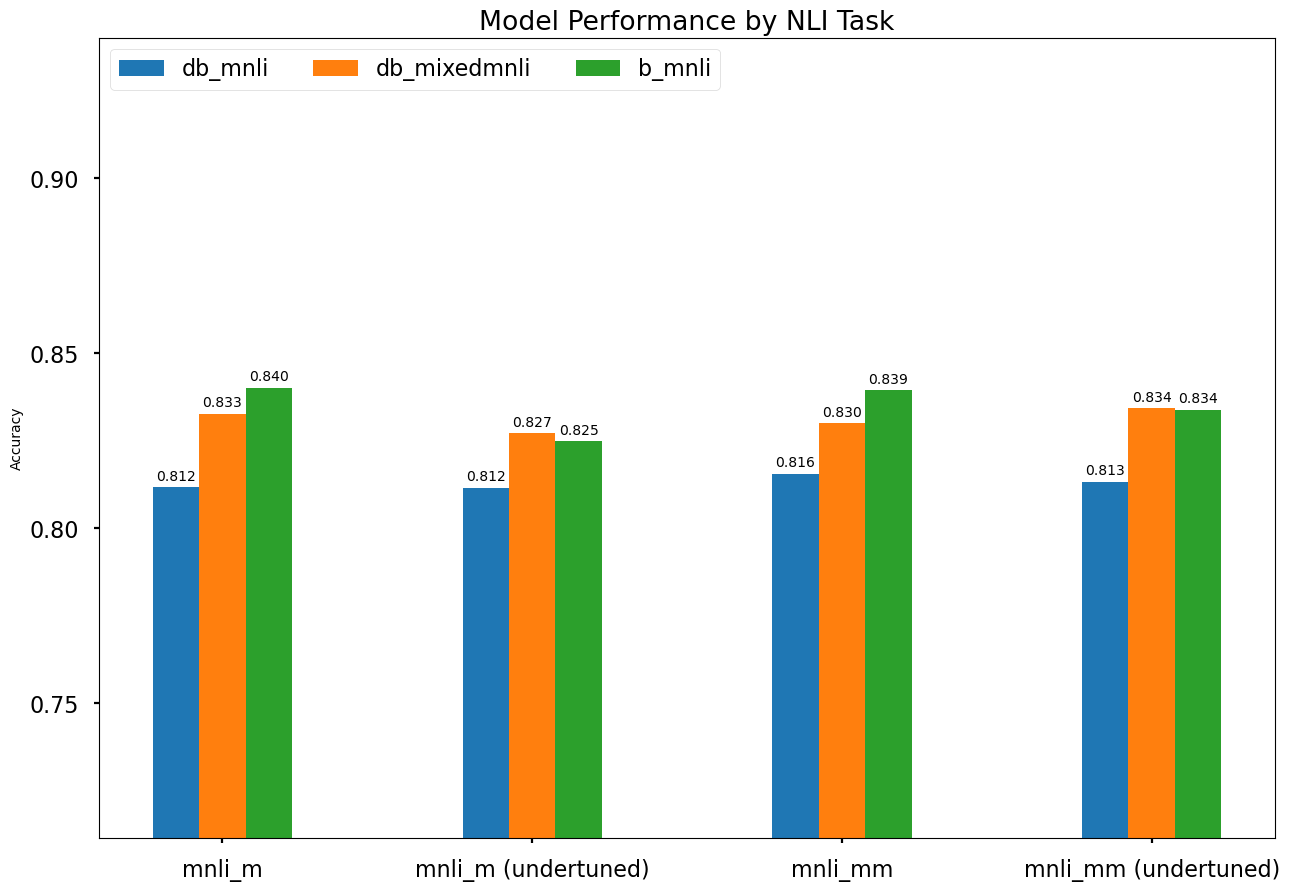

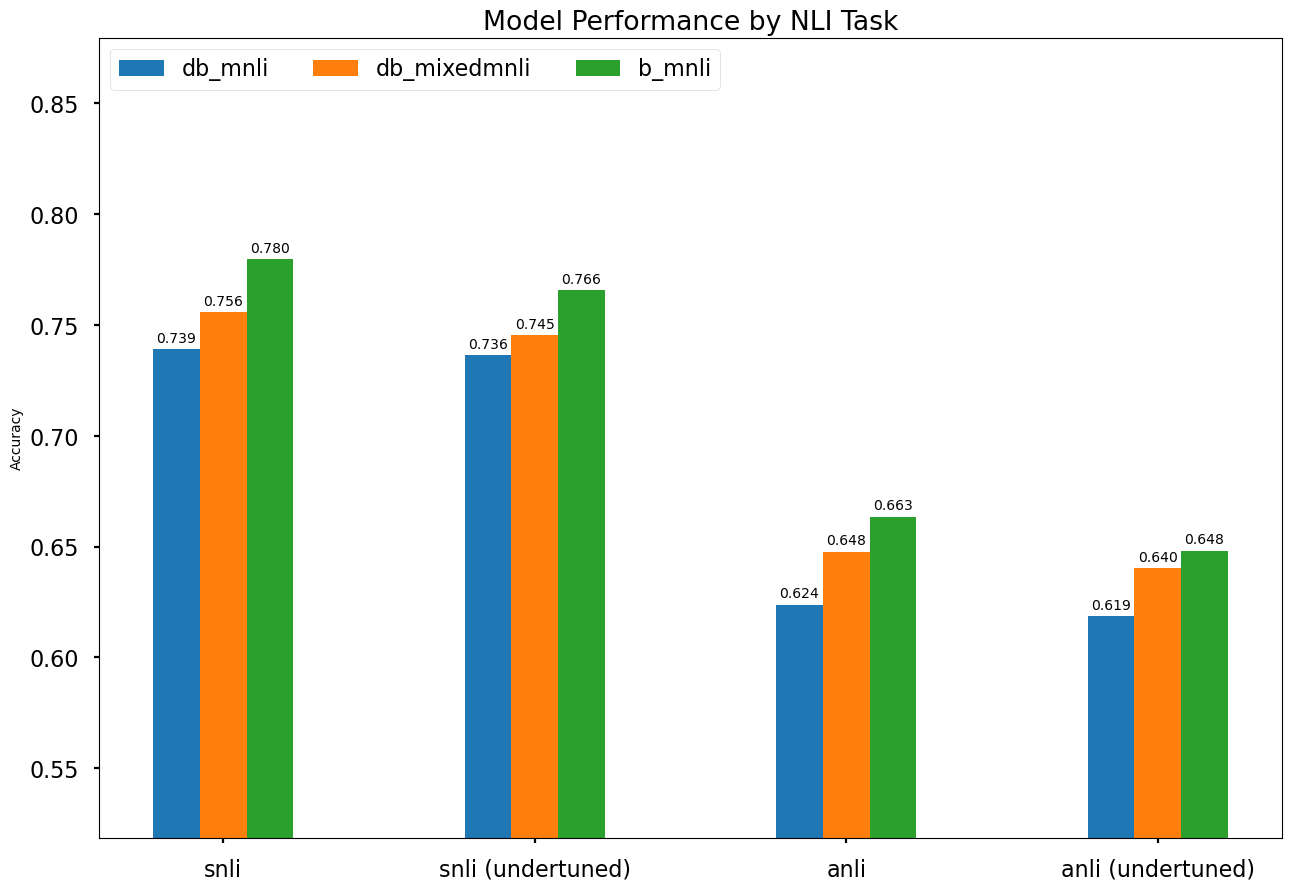

In [3]:
all_tasks = [
     'mnli_m',
     'mnli_m (undertuned)',
     'mnli_mm',
     'mnli_mm (undertuned)',
     'snli',
     'snli (undertuned)',
     'anli',
     'anli (undertuned)',
]
for i in range(0, len(all_tasks), 4):
    tasks = all_tasks[i:i+4]
    tune_types = ['db_mnli', 'db_mixedmnli', 'b_mnli']
    model_accs = {}
    gdf = pd.read_csv('data/gen_outputs.csv')
    gdf_old = pd.read_csv('data/gen_outputs_old.csv')
    for tt in tune_types:
        arch = 'distilbert' if tt[0] == 'd' else 'bert'
        subdf = gdf[gdf['m_arch'] == arch]
        subdf_old = gdf_old[gdf_old['m_arch'] == arch]
        model_accs[tt] = []
        tt_col = tt.split('_')[1]
        for task in tasks:
            if 'undertuned' in task:
                task = task[:-len(' (undertuned)')]
                val = subdf_old[(subdf_old['m_finetune'] == tt_col) & (subdf_old['dset'] == task)].acc
            else:
                val = subdf[(subdf['m_finetune'] == tt_col) & (subdf['dset'] == task)].acc
            model_accs[tt].append(val.item())
    get_bar_plots(tasks, model_accs)

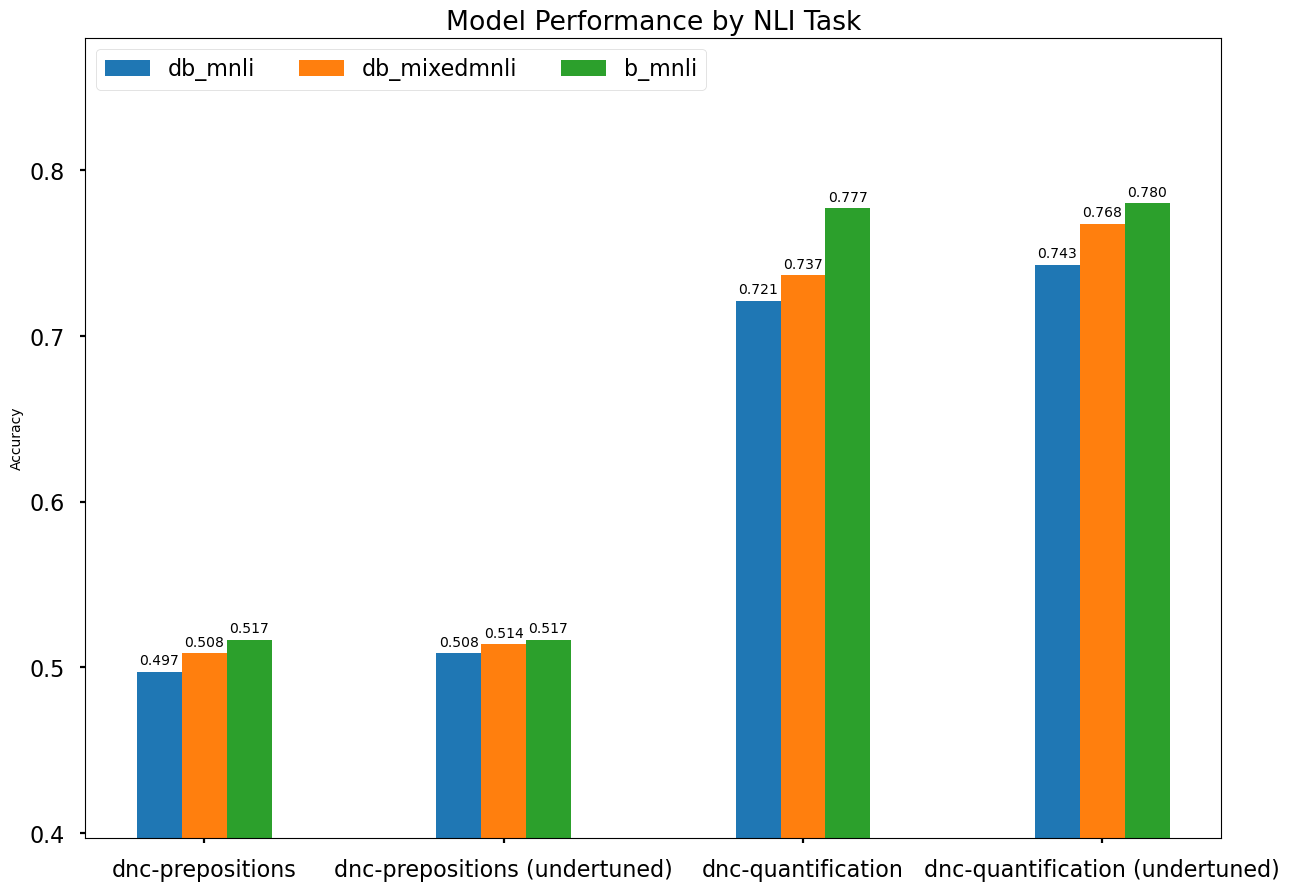

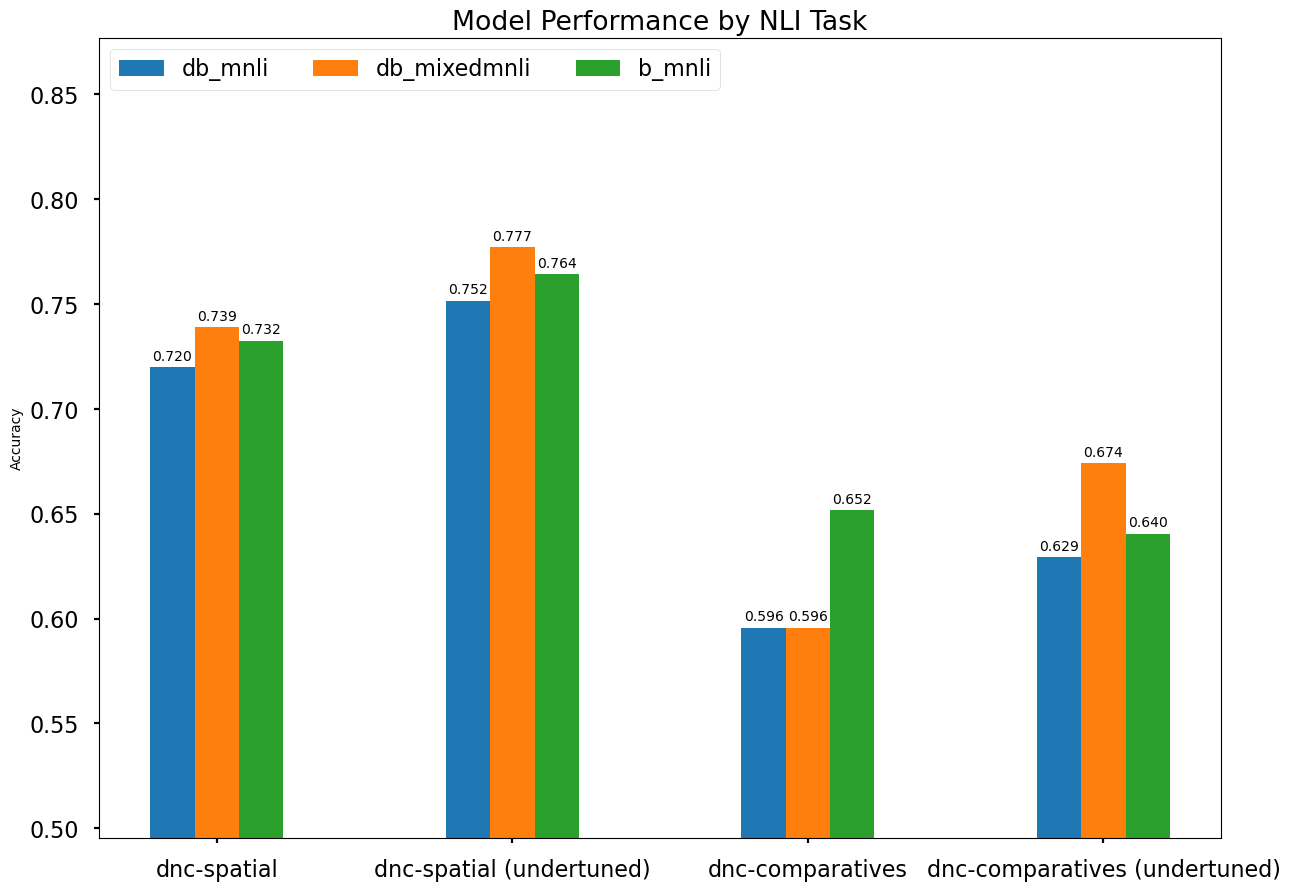

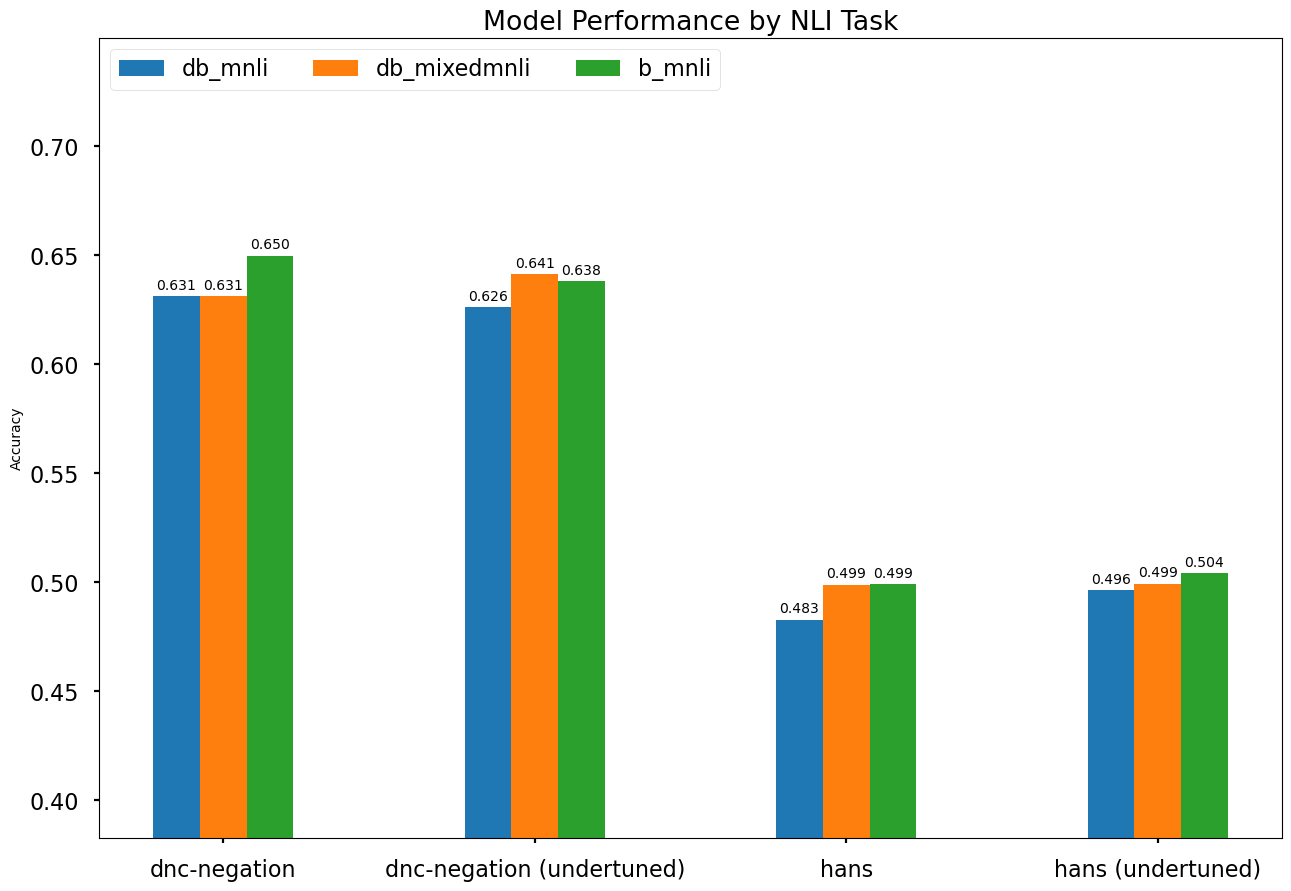

In [8]:
all_tasks = [
    'dnc-prepositions',
    'dnc-prepositions (undertuned)',
    'dnc-quantification',
    'dnc-quantification (undertuned)',
    'dnc-spatial',
    'dnc-spatial (undertuned)',
    'dnc-comparatives',
    'dnc-comparatives (undertuned)',
    'dnc-negation',
    'dnc-negation (undertuned)',
    'hans',
    'hans (undertuned)'
]
tune_types = ['db_mnli', 'db_mixedmnli', 'b_mnli']
model_accs = {}
gdf = pd.read_csv('data/gen_outputs.csv')
gdf_old = pd.read_csv('data/gen_outputs_old.csv')
for i in range(0, len(all_tasks), 4):
    tasks = all_tasks[i:i+4]
    for tt in tune_types:
        arch = 'distilbert' if tt[0] == 'd' else 'bert'
        subdf = gdf[gdf['m_arch'] == arch]
        subdf_old = gdf_old[gdf_old['m_arch'] == arch]
        model_accs[tt] = []
        tt_col = tt.split('_')[1]
        for task in tasks:
            if 'undertuned' in task:
                task = task[:-len(' (undertuned)')]
                val = subdf_old[(subdf_old['m_finetune'] == tt_col) & (subdf_old['dset'] == task)].acc
            else:
                val = subdf[(subdf['m_finetune'] == tt_col) & (subdf['dset'] == task)].acc
            model_accs[tt].append(val.item())
    get_bar_plots(tasks, model_accs)